In [62]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

# import zarr
# import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [63]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../weather')

In [64]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [65]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [66]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        f = self.encode_layer(x)
        f = self.ano1(f)
        f = self.ano2(f)
        f = self.ano3(f)
        f = self.decode_layer(f)
        return x + f

In [67]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y)**2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)

In [68]:
dtrain = np.load('../data/era5_train_small.npy', mmap_mode='r+')
nlat, nlon = dtrain.shape[1:]
dtrain = np.mean(dtrain.reshape(-1, 4, nlat, nlon), axis = 1)

# lag, lead = 1, 1
# xtrain, ytrain = split_data(dtrain, lag, lead)
dtrain = dtrain.squeeze()
# train_mu = np.mean(dtrain, axis = (0))[None,]
# train_sd = np.std(dtrain, axis = (0))[None,]

# dtrain = (dtrain - train_mu) / train_sd

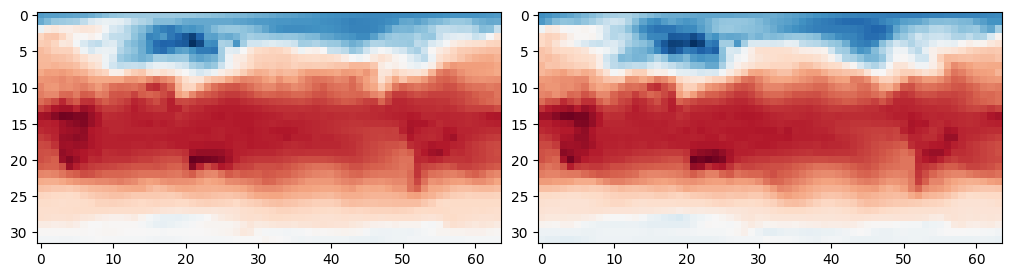

In [69]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(dtrain[0], cmap = 'RdBu_r')
ax[1].imshow(dtrain[1], cmap = 'RdBu_r')

In [70]:
lag, lead = 1, 1
xtrain, ytrain = split_data(dtrain, lag, lead)
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 64, shuffle = False)

In [71]:
epochs = 10
trace = []

model = DeepANO(lag, 100, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

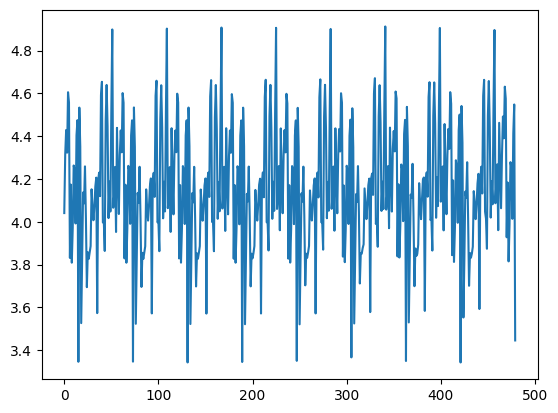

In [72]:
plt.plot(trace[100:])

In [73]:
quant = DeepANO(lag, 100, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [74]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)

# dval = (dval - train_mu) / train_sd
# dtest = (dtest - train_mu) / train_sd

xval, yval = split_data(dval, lag, lead)
xtest, ytest = split_data(dtest, lag, lead)

val_data = TensorDataset(torch.Tensor(xval), torch.Tensor(yval))
test_data = TensorDataset(torch.Tensor(xtest), torch.Tensor(ytest))
val_loader = DataLoader(val_data, batch_size = 100)
test_loader = DataLoader(test_data, batch_size = 100)

In [75]:
yval_hat = []
for xt, _ in tqdm(val_loader, leave = False):
    xt = torch2jax(xt)
    yval_hat.append(model(xt))

ytest_hat = []
for xt, _ in tqdm(test_loader, leave = False):
    xt = torch2jax(xt)
    ytest_hat.append(model(xt))

yval_quant = []
for xt, _ in tqdm(val_loader, leave = False):
    xt = torch2jax(xt)
    yval_quant.append(quant(xt))

ytest_quant = []
for xt, _ in tqdm(test_loader, leave = False):
    xt = torch2jax(xt)
    ytest_quant.append(quant(xt))

yval_hat = jnp.concat(yval_hat, axis = 0)
ytest_hat = jnp.concat(ytest_hat, axis = 0)
yval_quant = jnp.concat(yval_quant, axis = 0)
ytest_quant = jnp.concat(ytest_quant, axis = 0)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [76]:
nproj = nlat*nlon
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nsamp = 5000
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

In [77]:
# UQNO lambda estimate
yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.01
m = 30*60
tau = 2 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(1.8223848, dtype=float32)

In [78]:
yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze().reshape(-1, nlat*nlon)
rtest = (ytest - ytest_hat).squeeze().reshape(-1, nlat*nlon)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

In [80]:
i = 0
nsamp = 5000
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)
lsci_lower_i, lsci_upper_i = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)
uqno_lower_i, uqno_upper_i = uqn1_lower[i].reshape(nlat, nlon), uqn1_upper[i].reshape(nlat, nlon)
ytest_i = ytest[i].reshape(nlat, nlon)
rtest_i = rtest[i].reshape(nlat, nlon)
ytest_hat_i = ytest_hat[i].reshape(nlat, nlon)

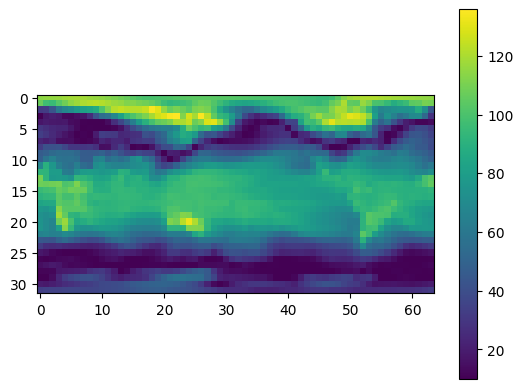

In [81]:
plt.imshow(uqno_upper_i - uqno_lower_i)
plt.colorbar()

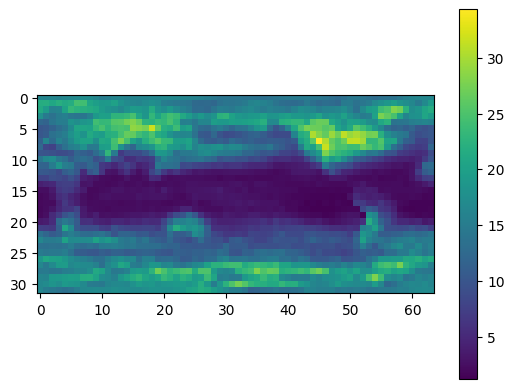

In [82]:
plt.imshow(lsci_upper_i - lsci_lower_i)
plt.colorbar()

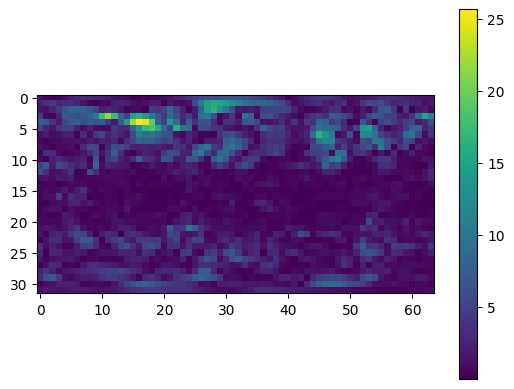

In [83]:
plt.imshow(2 * jnp.abs(rtest_i))
plt.colorbar()

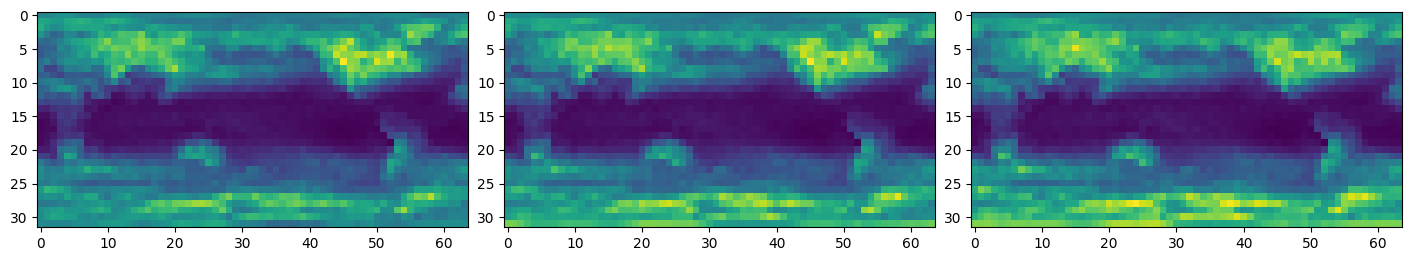

In [84]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (14, 4))

i = 0 * 31
nsamp = 2000
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)
lsci_lower_i, lsci_upper_i = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)

ax[0].imshow(lsci_upper_i - lsci_lower_i)

i = 3 * 31
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)
lsci_lower_i, lsci_upper_i = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)

ax[1].imshow(lsci_upper_i - lsci_lower_i)

i = 6 * 31
lsc1_lower, lsc1_upper = lsci.lsci(rval, 
                                   xval.reshape(-1, lag*nlat*nlon), 
                                   xtest[i].reshape(-1, lag*nlat*nlon), 
                                   pca_state, alpha1, gamma1, nsamp)
lsci_lower_i, lsci_upper_i = lsc1_lower.reshape(nlat, nlon), lsc1_upper.reshape(nlat, nlon)

ax[2].imshow(lsci_upper_i - lsci_lower_i)

In [85]:
rtest = rtest.reshape(-1, nlat, nlon)

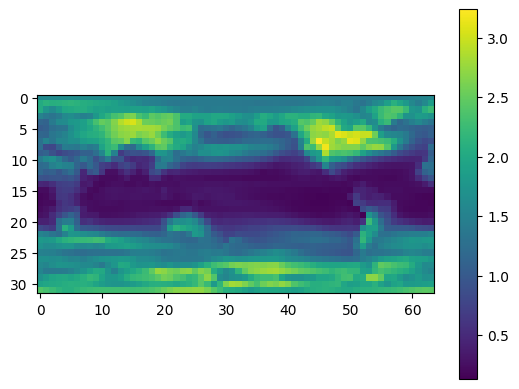

In [86]:
plt.imshow(jnp.mean(jnp.abs(rtest), axis = 0))
plt.colorbar()